In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm

from mypackage import *

# Generating isotropic gaussian random fields on the sphere using spherical harmonics


__Plan :__

1. A lat/lon grid is defined

2. We use the lemma in https://arxiv.org/pdf/1305.1170.pdf (section 5) to generate isotropic GRF on $\mathbb{S}^2$.

3. Plots

4. Verifications using an ensemble of GRFs to check the isotropic character of the random fields.
    
    
__Computing the anisotropic tensor on the sphere__ 

The anisotropic tensor (correlation sense) is related to the metric tensor (correlation sense) according to $\mathbf{s} = \mathbf{g}^{-1}$ (the matrix inverse). The metric tensor $\mathbf{g}$  (correlation sense) is defined by :
$$
g = \mathbb{E} \left[ \left( \nabla \tilde{\zeta} \right) \left( \nabla \tilde{\zeta} \right)^T \right],
$$

with $\nabla = \left(\frac{\partial}{\partial \theta}, \frac{1}{\cos \theta}\frac{\partial}{\partial \varphi} \right)$ for the sphere $\mathbb{S}^2$, and $\tilde{\zeta} = \zeta / \sigma $ the normalized error.


## 1. Defining the lat/lon grid

In [2]:
n = 360
grid = LatLonGrid(n)

## 2. GRF using spherical harmonics

Let $T$ be a centered isotropic Gaussian random field. For $l \in \mathbb{N}, m\in \{1,...,l\}$ and $\theta^\in ]-\pi/2, \pi/2[$, set 

$$
L_{lm}(\theta) = \sqrt{\frac{2l+1}{4\pi}\frac{(l-m)!}{(l+m)!}}P_{lm}(\sin \theta)
$$

Then for $y = (\cos \theta \cos \varphi, \cos\theta \sin\varphi,\sin \theta)$ there holds :

$$
\begin{align}
T(y) = \sum_{l=0}^\infty \left( \sqrt{A_l}X^1_{l0}L_{l0}(\theta)  + \sqrt{2A_l} \sum_{m=1}^l L_{lm}(\theta) (X^1_{lm}\cos(m\varphi)+X^2_{lm}\sin(m\varphi))\right)
\end{align}
$$
with :
> - $\left(X^1_{lm},X^2_{lm}\right)_{lm}$ a sequence of independant, real-valued, standard normally distributed random variables.
- $\left(A_l\right)_l$ a sequence of expotionnaly decaying real coefficients. It is the angular power spectrum.
- $P_{lm}$ the associated Legendre polynomials.

## 3. Plots 

#### planisphere

/home/perrota/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


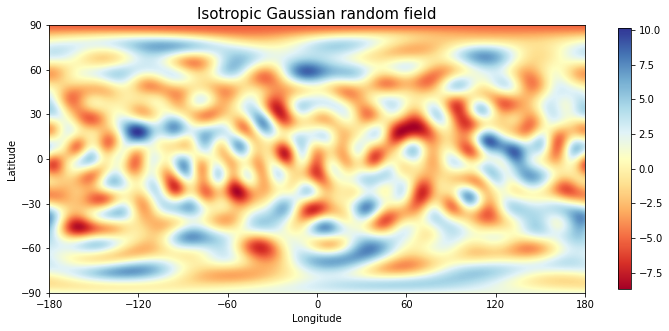

In [3]:
alpha=0.9

grf = grid.isotropic_grf(alpha=alpha)[0]

plt.figure(figsize=(12,6))
plt.title("Isotropic Gaussian random field",fontsize=15)
plt.imshow(grf.T,extent=[-180,180,-90,90],cmap='RdYlBu');
plt.colorbar(shrink=0.8);
plt.xlabel("Longitude"); plt.ylabel('Latitude');
plt.xticks(np.arange(-180,181,60));
plt.yticks(np.arange(-90,91,30));

#### spherical

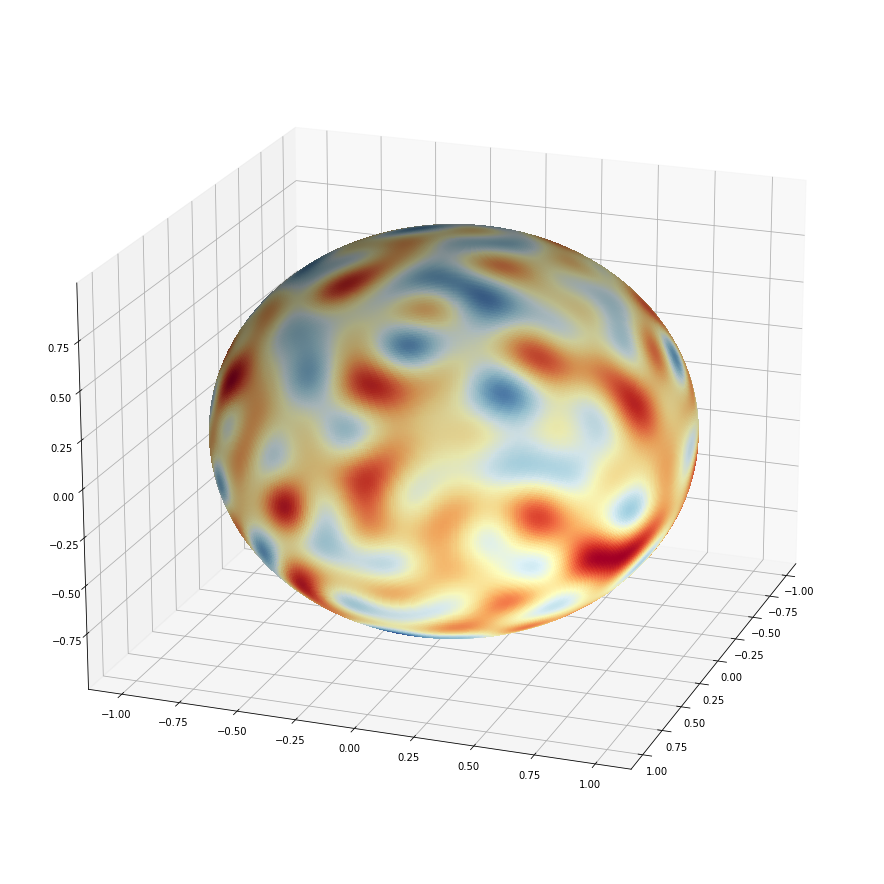

In [4]:
grid.sphere_plot(grf,cmap=cm.RdYlBu);

## 4. Sanity check

With verify that the random fields are well isotropic using an ensemble.

In [5]:
N = 1600
grfs = grid.isotropic_grf(N, alpha=alpha)
mean, std, aspect_tensor = grid.ensemble_diagnosis(grfs)

/home/perrota/Documents/spherical-advection/mypackage/tools/LatLonGrid.py:145: RuntimeWarning: divide by zero encountered in true_divide
  aspect_tensor =1/(metric_tensor[0,0] * metric_tensor[1,1] - metric_tensor[0,1]**2) * np.array([[metric_tensor[1,1],-metric_tensor[0,1]],
/home/perrota/Documents/spherical-advection/mypackage/tools/LatLonGrid.py:145: RuntimeWarning: invalid value encountered in multiply
  aspect_tensor =1/(metric_tensor[0,0] * metric_tensor[1,1] - metric_tensor[0,1]**2) * np.array([[metric_tensor[1,1],-metric_tensor[0,1]],


__Empirical estimation of the length-scale correlation__

As we can not prescribed a length-scale $l_h$ when generating the GRF, we diagnose it empirically after the ensemble generation as follows. 


$$
\hat{l}_h^2 = \frac{1}{m \cdot n} \sum_{i=1}^n\sum_{j=1}^m  \hat{\mathbf{s}}_{\theta \theta}(\theta_i,\varphi_j).
$$

It corresponds to the spatial average of the $\theta \theta$ entry of the empirically computed anisotropic tensor.

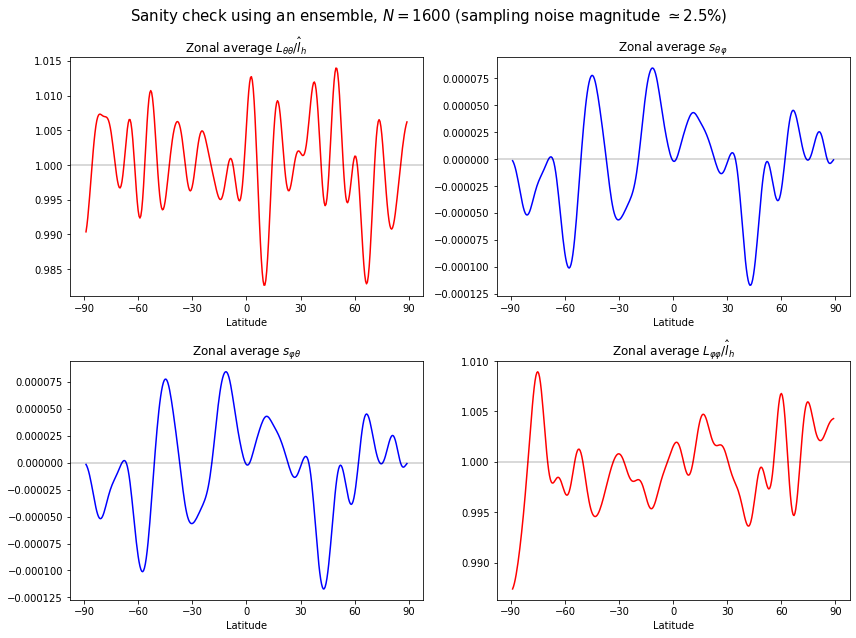

In [6]:
lh_hat = (aspect_tensor[0,0]**.5).mean()

chars = [r'$L_{\theta\theta}/\hat{l}_h$',r'$s_{\theta\varphi}$',r'$s_{\varphi\theta}$',r'$L_{\varphi\varphi}/\hat{l}_h$']

fig, ax = plt.subplots(2,2,figsize=(12,9))

fig.suptitle(fr"Sanity check using an ensemble, $N=${N} (sampling noise magnitude $\simeq${100/N**.5:.1f}%)"
             ,fontsize=15)
for i in range(2):
    for j in range(2):
        div_by = lh_hat*(i==j) + 1*(i!=j) ;power = 0.5*(i==j) + 1*(i!=j)
        title = chars[i*2+j]
        ax[i,j].set_title("Zonal average "+title);c = 'r' if i==j else 'b'
        ax[i,j].plot(grid.theta[1:-1]/(np.pi/2)*90,aspect_tensor[i,j].T.mean(axis=1)**power/div_by,c=c)
        ax[i,j].set_xticks([-90,-60,-30,0,30,60,90]) ;ax[i,j].set_xlabel("Latitude")
        ax[i,j].axhline(1*(i==j),c='k',alpha=0.2)
fig.tight_layout();

> - We observe that $L_{\theta\theta}$ and $L_{\varphi\varphi}$ are equal, and $s_{\theta\varphi}=0$.
- The random fields are effectively isotropic !